# Imports

In [212]:
print("Loading imports...")

# System imports
import os
import time
import sys
from glob import glob
import logging
logger = logging.getLogger(__name__)

# Analysis
import dedalus.public as d3
import numpy as np
import scipy as sp
import xarray as xr

# Auxiliary functions
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.bmh_colors import bmh_colors

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cmap = plt.cm.RdBu_r
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

print("Imports loaded")

Loading imports...
Imports loaded


# Auxiliary Functions

In [213]:
def day_to_index(day):
    return np.abs(downsampled_timepoints/SECONDS_PER_DAY - day).argmin()

# Problem Setup

## Physical Parameters

In [214]:
# Physical constants
SECONDS_PER_DAY = 24*3600
EARTH_RADIUS = 6.37122e6             # R_e [m]
Omega = 7.292e-5                     # Ω [rad s^-1]
GRAVITY = 9.80616                    # g [m s^-2]
EQUIVALENT_DEPTH = 250.              # H [m]
CORIOLIS_PARAMETER = 2.29e-11        # ß [m^-1 s^-1]
AIR_DENSITY = 1.225                  # ρ_a [kg m^-3]
WATER_DENSITY = 997                  # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                 # c_p [J kg^-1]
GROSS_DRY_STABILITY = 3.12e4         # M_s [K kg m^-2] 
CLOUD_RADIATIVE_PARAMETER = 0.2      # r   [-]

gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)            # c [m s^-2]
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY                # M_q [K kg m^-2]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)     # L [m]
METERS_PER_RADIAN = 2*np.pi*EARTH_RADIUS/(2*np.pi)
length_scale /= METERS_PER_RADIAN

# Convective parameterization
# <Q_c> = ε_q <q> - ε_t <T> 
TEMPERATURE_SENSITIVITY = 1/(2 * 3600)        # ε_t [s^-1]
MOISTURE_SENSITIVITY = 1/(6 * 3600)           # ε_q [s^-1]

# Moistening due to mean state moisture
ZONAL_MOISTENING_MULTIPLIER = 0                       # n_x
MERIDIONAL_MOISTENING_MULTIPLIER = 1                  # n_y 

ZONAL_MOISTENING = 5e-4*ZONAL_MOISTENING_MULTIPLIER               # σ_x [K kg m^-3] 
MERIDIONAL_MOISTENING = 8e-9*MERIDIONAL_MOISTENING_MULTIPLIER     # σ_y [K kg m^-4]

## Simulation Parameters

In [215]:
# equation_set = 'dry-Matsuno'
equation_set = 'Ahmed21'
n_wavelengths = 2
initial_condition = f"pseudo-Kelvin-wave"

simulation_moisture = False
if equation_set == 'Ahmed21':
    simulation_moisture = True

# Simulation units
meter = 1
second = 1
hour = 3600 * second
day = 24 * hour
kilogram = 1
Kelvin = 1
Joule = kilogram * meter**2 / second**2

# Grid parameters
Nphi = 32
Ntheta = 64
dealias = 3/2
dtype = np.float64

# Timestepping parameters
timestepper = d3.RK222
timestep = 600 * second
simulation_length = 360 * day
total_iterations = simulation_length//timestep
downsample_interval = 6 * hour

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=EARTH_RADIUS, dealias=dealias, dtype=dtype)
e_phi = dist.VectorField(coords, bases=basis)
e_theta = dist.VectorField(coords, bases=basis)
e_phi['g'][0] = 1
e_theta['g'][1] = 1

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
T = dist.Field(name='T', bases=basis)
q = dist.Field(name='q', bases=basis)

# Substitutions
zcross = lambda A: d3.MulCosine(d3.skew(A))

# Initial condition

## Specify

In [216]:
# Initialize local grids
phi, theta = dist.local_grids(basis)
latitude = np.pi / 2 - theta
n_wavelengths = 2

ncc_cot = dist.Field(name='cot', bases=basis)
ncc_cot['g'] = 1/np.tan(theta)

#### Spherical Harmonics
if initial_condition == 'spherical-harmonics':
    harmonic = sp.special.sph_harm(1, 1, phi, theta)
    u['g'][0] = gravity_wave_phase_speed * np.real(harmonic)
    T['g'] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2 * np.real(harmonic)
    if simulation_moisture:
        q['g'] = -(gross_moisture_stratification/gravity_wave_phase_speed**2) * gravity_wave_phase_speed * np.real(harmonic)

#### Pseudo-Kelvin wave
elif initial_condition == 'pseudo-Kelvin-wave':
    initial_wavenumber = 2*np.pi*n_wavelengths/(2*np.pi)
    u['g'][0] = gravity_wave_phase_speed * np.cos(initial_wavenumber*phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)
    T['g'] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2) * gravity_wave_phase_speed * np.cos(initial_wavenumber*phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)
    if simulation_moisture:
        q['g'] = -(gross_moisture_stratification/gravity_wave_phase_speed**2) * gravity_wave_phase_speed * np.cos(initial_wavenumber*phi) * np.exp(-((theta-np.pi/2)/length_scale)**2)

elif initial_condition == 'pseudo-Rossby-wave':
    mode_number = 1
    initial_wavenumber = 2*np.pi*n_wavelengths/(2*np.pi)
    initial_frequency = (
                CORIOLIS_PARAMETER*initial_wavenumber
                /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
            )

    # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
    u['g'][1] = np.real(
            np.einsum(
                'i,j->ji',
                (
                    1j*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)*(1/CORIOLIS_PARAMETER)
                        *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number)
                ),
                np.exp(1j*initial_wavenumber*phi.squeeze())
            )
        )

    # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
    u['g'][0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ji',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number + 1)
                    + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number - 1)
                ),
                np.exp(1j*initial_wavenumber*phi.squeeze())
            )
        )

    # <T>(x,y,t=0) =  (M_s/c) x L × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [K kg m^-2]
    T['g'] = (
        GROSS_DRY_STABILITY/gravity_wave_phase_speed
    )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
            np.einsum(
                'i,j->ji',
                (
                    0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number + 1)
                    - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                        *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number - 1)
                ),
                np.exp(1j*initial_wavenumber*phi.squeeze())
            )
        )

    if simulation_moisture == True:
        q['g'] = -(
            gross_moisture_stratification/gravity_wave_phase_speed
        )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ji',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number + 1)
                        - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*phi.squeeze())
                )
            )

    u['g'][0] /= np.max(T['g'])
    u['g'][1] /= np.max(T['g'])
    T['g'] /= np.max(T['g'])
    q['g'] /= np.max(T['g'])

#### Parabolic cylinder functions 
elif initial_condition == 'parabolic-cylinder-functions':
    initial_wavenumber = 2*np.pi*4/(2*np.pi)
    # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
    u['g'][0] = gravity_wave_phase_speed*np.real(
        np.einsum(
            'i,j->ji',
            mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, 0),
            np.exp(1j*initial_wavenumber*phi.squeeze())
        )
    )
    
    # <T>(x,y,t=0)
    T['g'] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ji',
            mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, 0),
            np.exp(1j*initial_wavenumber*phi.squeeze())
        )
    )

    if simulation_moisture:
        q['g'] = -(gross_moisture_stratification/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
        np.einsum(
            'i,j->ji',
            mjo.parabolic_cylinder_function(latitude.squeeze()/length_scale, 0),
            np.exp(1j*initial_wavenumber*phi.squeeze())
        )
    )

elif initial_condition == 'temperature-blob':
    T['g'] = (
        (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2) * gravity_wave_phase_speed 
        * np.exp(-((phi - np.pi)/(2*length_scale))**2)
        * np.exp(-((theta - np.pi/2)/(2*length_scale))**2)
    )

if equation_set == 'Ahmed21':
    ncc_theta = dist.Field(bases=basis)
    gaussian_length_scale = 0.47511444471086184
    ncc_theta['g'] = EARTH_RADIUS*latitude*np.exp(-(latitude/gaussian_length_scale)**2)

    # cutoff_latitude = np.pi/6
    # cutoff_latitude = np.pi/12
    # above_cutoff = np.where(latitude > cutoff_latitude)
    # below_cutoff = np.where(latitude < -cutoff_latitude)
    
    # width = np.pi/8
    # above_function = cutoff_latitude*np.exp(-((latitude[above_cutoff]-cutoff_latitude)/width)**2)
    # below_function = -cutoff_latitude*np.exp(-((latitude[below_cutoff]+cutoff_latitude)/width)**2)
    
    # ncc_theta['g'][:, above_cutoff] = EARTH_RADIUS*above_function
    # ncc_theta['g'][:, below_cutoff] = EARTH_RADIUS*below_function
    # ncc_theta['g'][:, 0] = ncc_theta['g'][:, -1] = 0

### Plot NCC meridional advection

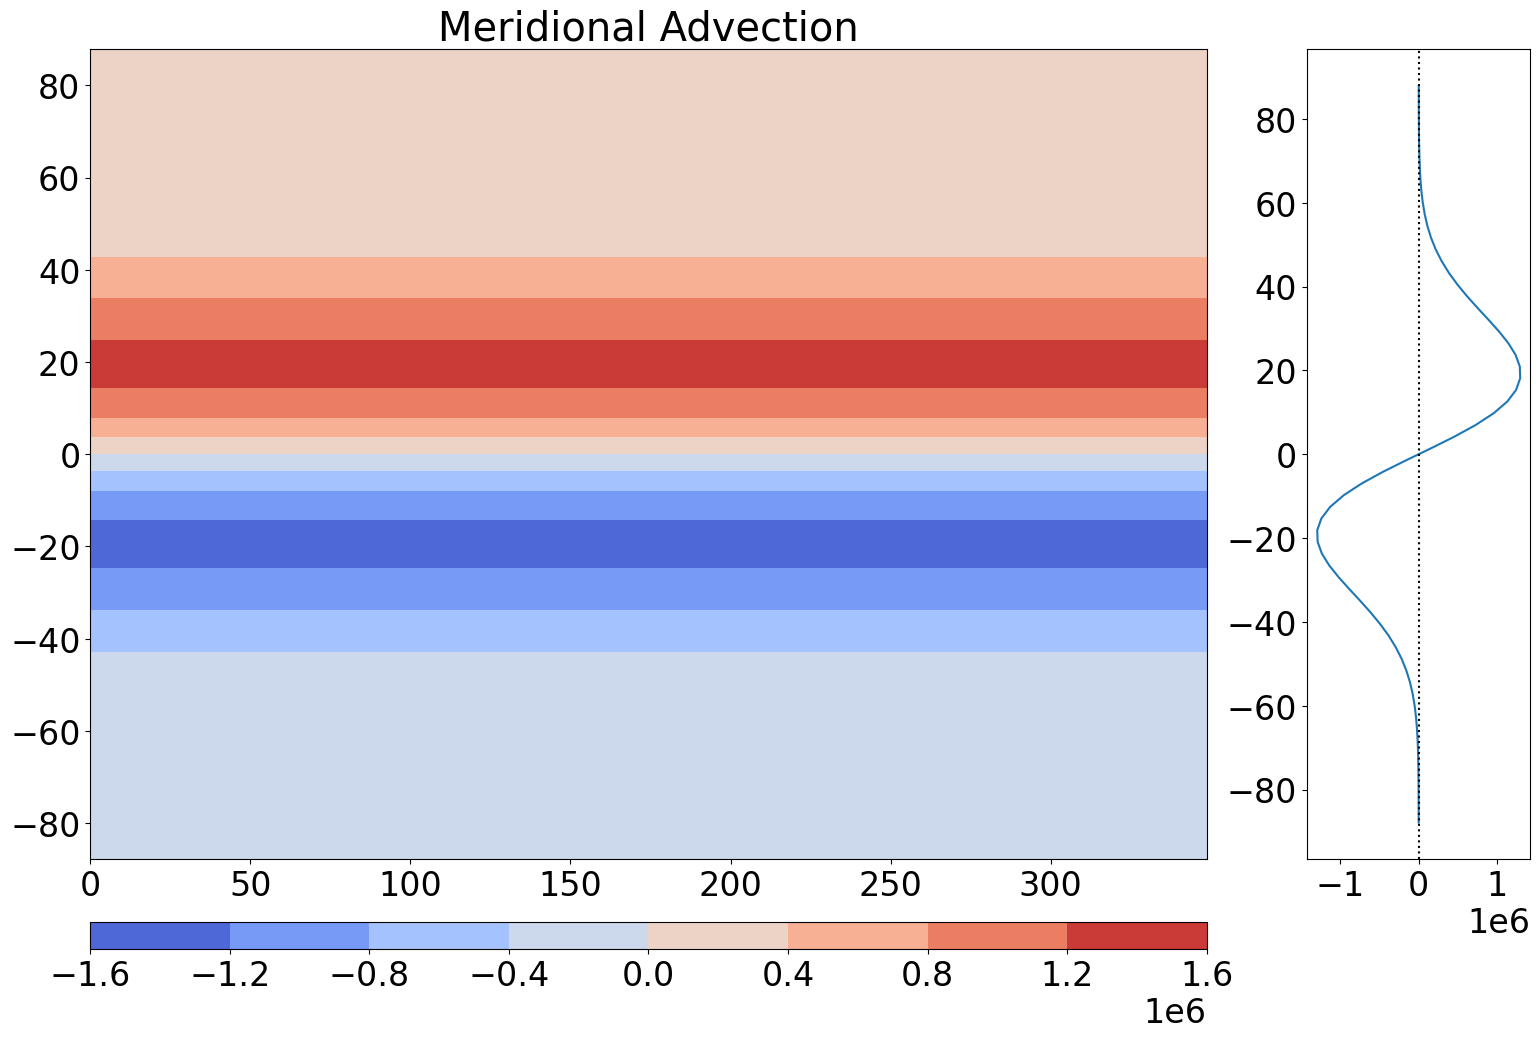

In [217]:
if equation_set == 'Ahmed21':
    plt.style.use('default')
    plt.rcParams.update({'font.size':24})
    fig = plt.figure(figsize=(16,10))
    gs = GridSpec(2, 2, width_ratios=[5,1], height_ratios=[30,1], figure=fig)
    gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0.15, wspace=0.15)
    
    ax = []
    ax.append(fig.add_subplot(gs[0,0]))
    ax.append(fig.add_subplot(gs[0,1]))
    cbar_ax = fig.add_subplot(gs[1,0])
    ax[0].set_title('Meridional Advection')
    CF = ax[0].contourf(
        180*phi.squeeze()/np.pi,
        180*latitude.squeeze()/np.pi,
        ncc_theta['g'].T, cmap='coolwarm', norm=mcolors.CenteredNorm(vcenter=0))
    fig.colorbar(CF, cax=cbar_ax, orientation='horizontal')
    ax[0].set_aspect('auto')
    ax[0].set_yticks(np.arange(-80, 100, 20)) 
                     
    
    ax[1].plot(
        ncc_theta['g'][0,:],
        180*latitude.squeeze()/np.pi,
    )
    ax[1].axvline(x=0, color='k', ls=':')
    ax[1].set_aspect('auto')
    ax[1].set_yticks(np.arange(-80, 100, 20))
    plt.show()

## Plot initial condition

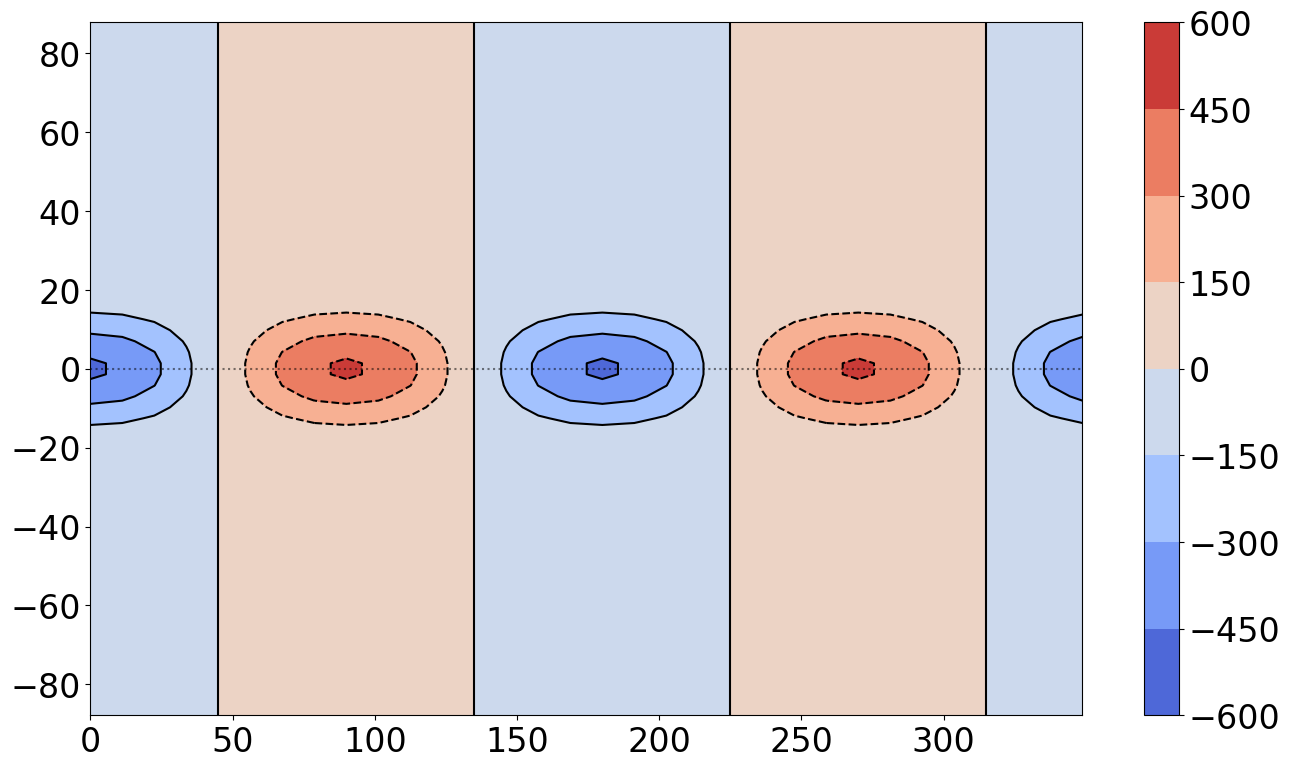

In [218]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
plt.figure(figsize=(16,9))
plt.contour(
    (180*phi.squeeze()/np.pi),
    (180*latitude.squeeze()/np.pi),
    T['g'].T, 
    colors='k',
)

plt.quiver(
    (180*phi.squeeze()/np.pi), 
    (180*latitude.squeeze()/np.pi), 
    u['g'][0].T, 
    u['g'][1].T,
)

if simulation_moisture:
    plt.contourf(
        (180*phi.squeeze()/np.pi),
        (180*latitude.squeeze()/np.pi),
        q['g'].T, 
        cmap='coolwarm',
    )
    plt.colorbar()

# plt.gca().invert_yaxis()
plt.axhline(y=0, ls=':', color='k', alpha=0.5)
plt.gca().set_aspect('auto')
plt.show()

# Build IVP solver

In [219]:
print(f"Equation Set: {equation_set}")

if equation_set == 'example':
    problem = d3.IVP([u, h], namespace=locals())
    problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
    problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = - div(h*u)")
    

elif equation_set == 'linearized-example':
    problem = d3.IVP([u, h], namespace=locals())
    problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) = - 2*Omega*ncc_theta*zcross(u)")
    problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = 0")

elif equation_set == 'Ahmed21':
    problem = d3.IVP([u, T, q], namespace=locals())
    problem.add_equation(
        "dt(u) + 2*Omega*zcross(u) + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*grad(T) = 0"
    )
    problem.add_equation(
        "dt(T) + GROSS_DRY_STABILITY*div(u) + TEMPERATURE_SENSITIVITY*(1 + CLOUD_RADIATIVE_PARAMETER)*T - MOISTURE_SENSITIVITY*(1 + CLOUD_RADIATIVE_PARAMETER)*q = 0"
    )
    problem.add_equation(
        "dt(q) - gross_moisture_stratification*div(u) - TEMPERATURE_SENSITIVITY*T + MOISTURE_SENSITIVITY*q = ZONAL_MOISTENING*(e_phi@u) - MERIDIONAL_MOISTENING*ncc_theta*(e_theta@u)"
    )

elif equation_set == 'dry-Matsuno':
    problem = d3.IVP([u, T], namespace=locals())
    problem.add_equation("dt(u) + 2*Omega*zcross(u) + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*grad(T) = 0")
    problem.add_equation("dt(T) +  GROSS_DRY_STABILITY*div(u)")

# Solver
print("Building solver...")
solver = problem.build_solver(timestepper)
solver.stop_sim_time = simulation_length
print("Solver built")

Equation Set: Ahmed21
Building solver...
2024-03-11 17:39:43,963 subsystems 0/1 INFO :: Building subproblem matrices 1/16 (~6%) Elapsed: 0s, Remaining: 1s, Rate: 1.9e+01/s
2024-03-11 17:39:44,003 subsystems 0/1 INFO :: Building subproblem matrices 2/16 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.2e+01/s
2024-03-11 17:39:44,084 subsystems 0/1 INFO :: Building subproblem matrices 4/16 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.3e+01/s
2024-03-11 17:39:44,166 subsystems 0/1 INFO :: Building subproblem matrices 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2024-03-11 17:39:44,246 subsystems 0/1 INFO :: Building subproblem matrices 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2024-03-11 17:39:44,327 subsystems 0/1 INFO :: Building subproblem matrices 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2024-03-11 17:39:44,400 subsystems 0/1 INFO :: Building subproblem matrices 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2024-03-11 17:39:44,466 subsystems

# Run 

In [220]:
# Output logging
log_interval = 15 * day
max_logs = 100
num_logs = int(simulation_length/log_interval)
if num_logs > max_logs:
    print(f"Log interval ({log_interval/hour} hour) creates too many logs ({num_logs}), capping number of logs at {max_logs}")
    log_interval = int(simulation_length / max_logs)
    num_logs = max_logs
else:
    print(f"Log interval = {log_interval/hour} hour(s), number of logs = {num_logs:0.0f}")

# Output file directory
output_file_directory = f"modified_spherical_shallow_water_equations/{equation_set}-solver" 
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)

additional_notes = ''
if equation_set == 'Ahmed21':
    additional_notes = ''
    experiment_name = (
        f"epst={3600*TEMPERATURE_SENSITIVITY:0.2f}_epsq={3600*MOISTURE_SENSITIVITY:0.2f}_r={CLOUD_RADIATIVE_PARAMETER:0.2f}"
        + f"_nx={ZONAL_MOISTENING_MULTIPLIER:0.2f}_ny={MERIDIONAL_MOISTENING_MULTIPLIER:0.2f}"
        + f"{additional_notes}"
    )

elif equation_set == 'dry-Matsuno':
    additional_notes = '_curvature-term'
    experiment_name = f"H={EQUIVALENT_DEPTH:0.2f}{additional_notes}"

print(f"Experiment saved as: {experiment_name}")

initial_condition_name = f"{initial_condition}_k={n_wavelengths:.0f}_initial-condition"

# Make snapshots folder
if not os.path.exists(f"{output_file_directory}/{experiment_name}"):
    os.system(f"mkdir {output_file_directory}/{experiment_name}")
    # os.system(f"mkdir {output_file_directory}/{experiment_name}/{initial_condition_name}")

# Analysis
snapshots = solver.evaluator.add_file_handler(
    f"{output_file_directory}/{experiment_name}/{initial_condition_name}",
    sim_dt=downsample_interval,
    max_writes = 4000
)
snapshots.add_tasks(solver.state)

start_time = time.time()
# Main loop
try:
    logger.info('Starting main loop...')
    logger.info(
        f"{'Iteration':^{2*len(str(total_iterations))+1}}  "
        + f"{'%':>7} "
        + f"{'Sim Time (hr)':>{2*len(str(simulation_length//3600))+7}}  "
        + f"{'Timestep (s)':>{12}}   "
        + f"{'Wall Time (min)':>{12}}"
    )
    while solver.proceed:
        solver.step(timestep)
        # if (solver.iteration) % int(round_out(total_iterations, 'hundreds')/num_logs) == 0:
        if (solver.iteration == 1) or (round(solver.sim_time, 1) % log_interval == 0.0):
            iter_string = f"{solver.iteration:>{len(str(total_iterations))}.0f}/{total_iterations:0.0f}" 
            percent_string = f"{100*solver.iteration/total_iterations:>.1f}"
            time_string = f"{solver.sim_time/3600:>{len(str(simulation_length//3600))}.0f}/{simulation_length/3600:.0f}"
            timestep_string = f"{timestep:>{len(f'{timestep:0.1f}')}.1f}"
            wall_time_string = f"{(time.time() - start_time)/60:>12.2f}"

            logger.info(f"{iter_string}  {percent_string:>7}     {time_string}      {timestep_string}     {wall_time_string}")
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

end_time = time.time()
print(f"Wall time : {(end_time - start_time)/60:0.2f} minutes")

Log interval = 360.0 hour(s), number of logs = 24
Experiment saved as: epst=0.50_epsq=0.17_r=0.20_nx=0.00_ny=1.00
2024-03-11 17:39:51,328 __main__ 0/1 INFO :: Starting main loop...
2024-03-11 17:39:51,329 __main__ 0/1 INFO ::  Iteration         %   Sim Time (hr)  Timestep (s)   Wall Time (min)
2024-03-11 17:39:53,391 __main__ 0/1 INFO ::     1/51840      0.0        0/8640      600.0             0.03
2024-03-11 17:40:36,356 __main__ 0/1 INFO ::  2160/51840      4.2      360/8640      600.0             0.75
2024-03-11 17:41:19,779 __main__ 0/1 INFO ::  4320/51840      8.3      720/8640      600.0             1.47
2024-03-11 17:42:03,437 __main__ 0/1 INFO ::  6480/51840     12.5     1080/8640      600.0             2.20
2024-03-11 17:42:47,087 __main__ 0/1 INFO ::  8640/51840     16.7     1440/8640      600.0             2.93
2024-03-11 17:43:30,726 __main__ 0/1 INFO :: 10800/51840     20.8     1800/8640      600.0             3.66
2024-03-11 17:44:14,350 __main__ 0/1 INFO :: 12960/51840 

# Analyze data

## Load output data

In [221]:
print(f"Experiment: {experiment_name}")
print("Loading output data...")

# output_data_files = glob(f"modified_spherical_shallow_water_equations/{experiment_name}/{experiment_name}_s*.h5")
output_data_files = glob(f"{output_file_directory}/{experiment_name}/{initial_condition_name}/*.h5")
temperature_list = []
moisture_list = []
velocity_list = []
for data_file in output_data_files: 
    print(f"---- {data_file}")
    temperature_list.append(d3.load_tasks_to_xarray(data_file)['T'])
    velocity_list.append(d3.load_tasks_to_xarray(data_file)['u'])
    if simulation_moisture:
        moisture_list.append(d3.load_tasks_to_xarray(data_file)['q'])

output_temperature = xr.concat(temperature_list, dim='t')
output_velocity = xr.concat(velocity_list, dim='t')
if simulation_moisture:
    output_moisture = xr.concat(moisture_list, dim='t')
print("Output data loaded")

downsampled_timepoints = output_temperature.t

Experiment: epst=0.50_epsq=0.17_r=0.20_nx=0.00_ny=1.00
Loading output data...
---- modified_spherical_shallow_water_equations/Ahmed21-solver/epst=0.50_epsq=0.17_r=0.20_nx=0.00_ny=1.00/pseudo-Kelvin-wave_k=2_initial-condition/pseudo-Kelvin-wave_k=2_initial-condition_s1.h5
Output data loaded


## 3D Plots

### Define spherical coordinate vertices

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def build_s2_coord_vertices(phi, theta):
    phi = phi.ravel()
    phi_vert = np.concatenate([phi, [2*np.pi]])
    phi_vert -= phi_vert[1] / 2
    theta = theta.ravel()
    theta_mid = (theta[:-1] + theta[1:]) / 2
    theta_vert = np.concatenate([[np.pi], theta_mid, [0]])
    return np.meshgrid(phi_vert, theta_vert, indexing='ij')

### Animate in 3D

In [ ]:
phi = output_moisture.phi.values
theta = output_moisture.theta.values
phi_vert, theta_vert = build_s2_coord_vertices(phi, theta)
x = np.sin(theta_vert) * np.cos(phi_vert)
y = np.sin(theta_vert) * np.sin(phi_vert)
z = np.cos(theta_vert)


fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')

def update(t):
    ax.clear()
    
    clim = np.max(np.abs(output_moisture.isel(t=t).values))
    norm = mcolors.Normalize(-clim, clim)
    fc = cmap(norm(output_moisture.isel(t=t).values))
    
    surf = ax.plot_surface(x, y, z, facecolors=fc, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
    ax.set_box_aspect((1,1,1))
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    ax.axis('off')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(0, 360, 6), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=30
)

anim.save(f"{output_file_directory}/{experiment_name}/{initial_condition_name}/global_plots.mp4", dpi=200)

## 2D Plots

### Single timestep

#### Natural coordinates

In [ ]:
t = -1

# Create dedalus field objects for each of the variables
output_temperature_field = dist.Field(name='output_temperature', bases=basis)
output_moisture_field = dist.Field(name='output_moisture', bases=basis)
output_zonal_velocity_field = dist.Field(name='output_zonal_velocity', bases=basis)
output_meridional_velocity_field = dist.Field(name='output_meridional_velocity', bases=basis)

# Set the grid of the field objects to the value of the output array
output_temperature_field['g'] = output_temperature.isel(t=t)
output_moisture_field['g'] = output_moisture.isel(t=t)
output_zonal_velocity_field['g'] = output_velocity.isel(t=t)[0]
output_meridional_velocity_field['g'] = output_velocity.isel(t=t)[1]

# Scale the fields according to the upscale factor
upscaling_factor = 8
output_temperature_field.change_scales(upscaling_factor)
output_moisture_field.change_scales(upscaling_factor)
output_zonal_velocity_field.change_scales(upscaling_factor)
output_meridional_velocity_field.change_scales(upscaling_factor)
[output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)


fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

CS = ax.contour(
    output_phi.squeeze(),
    output_theta.squeeze(),
    output_temperature_field['g'].T,
    colors = 'k',
    norm=mcolors.CenteredNorm(vcenter=0),
)

CF = ax.contourf(
    output_phi.squeeze(),
    output_theta.squeeze(),
    output_moisture_field['g'].T,
    cmap='coolwarm', 
    norm=mcolors.CenteredNorm(vcenter=0),
)
fig.colorbar(CF, cax=cbar_ax)

phi_quiver_spacing = 6
theta_quiver_spacing = 18

ax.quiver(
    output_phi.squeeze()[::phi_quiver_spacing],
    output_theta.squeeze()[::theta_quiver_spacing],
    output_zonal_velocity_field['g'][::phi_quiver_spacing, ::theta_quiver_spacing].T, 
    output_meridional_velocity_field['g'][::phi_quiver_spacing, ::theta_quiver_spacing].T, 
)
ax.axhline(y=np.pi/2, ls=':', color='k', alpha=0.5)

ax.invert_yaxis()
ax.set_xlabel('phi')
ax.set_ylabel('theta')
ax.set_aspect('auto')
plt.show()

#### Lat/Lon coordinates

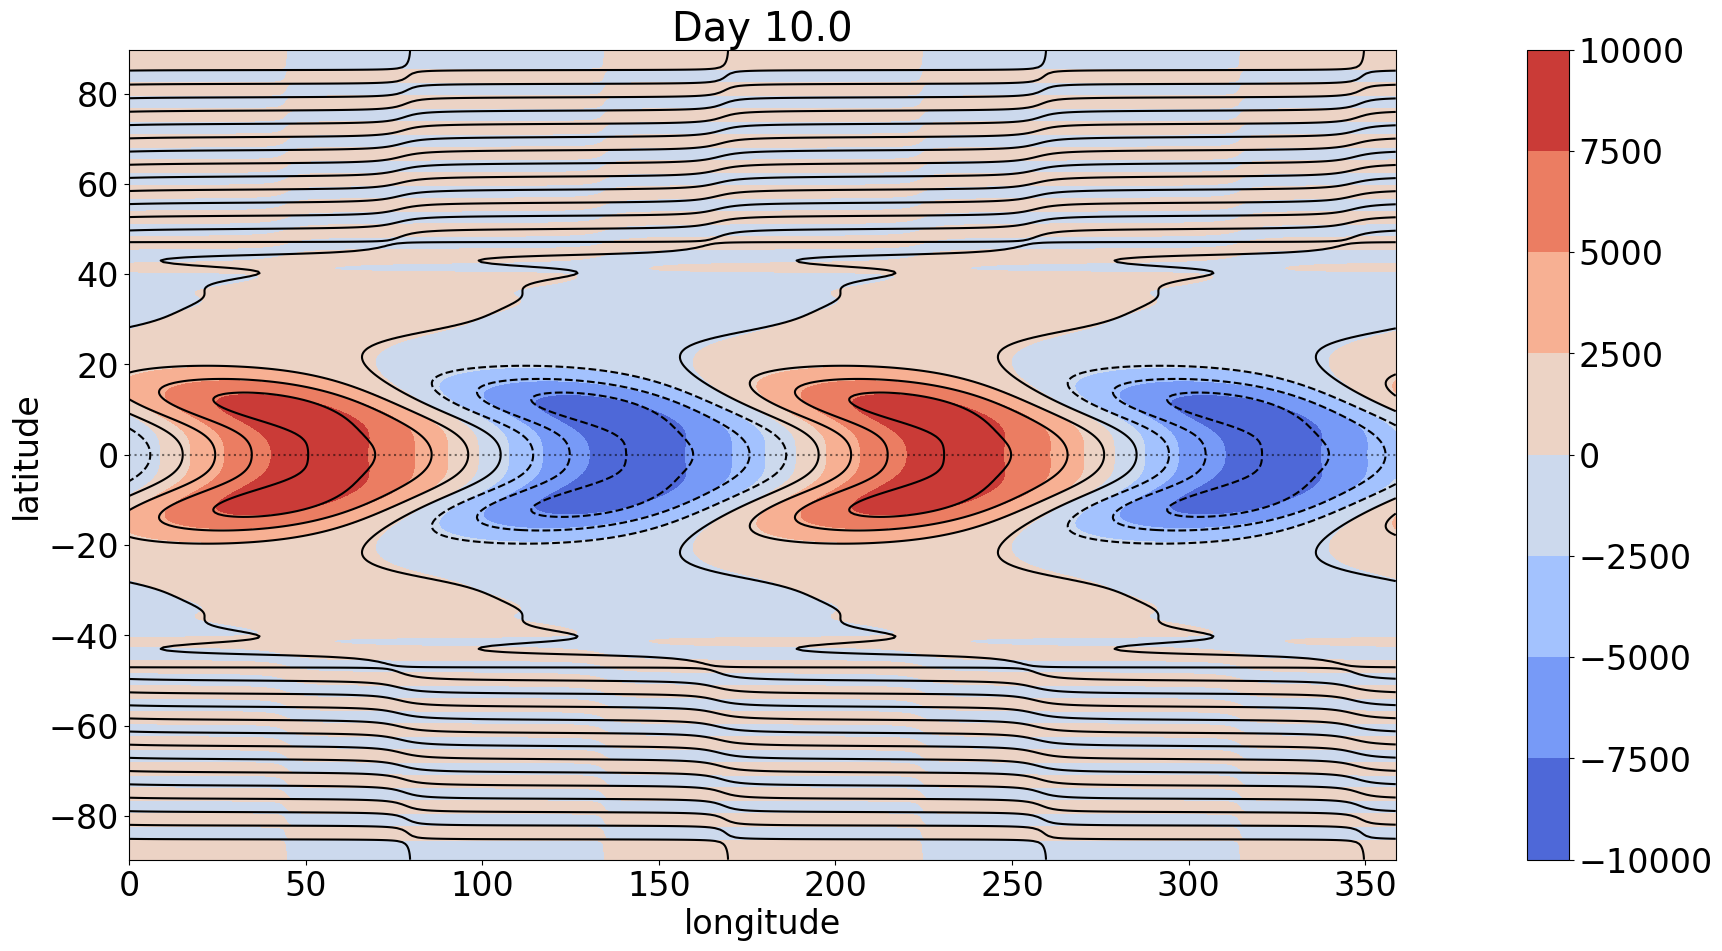

[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 213
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 50
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 5
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 0
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 32
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 0
[wind:1641305] tcp_peer_recv_connect_ack: invalid header type: 0


In [224]:
t = day_to_index(10)
upscaling_factor = 8

# Create dedalus field objects for each of the variables
output_temperature_field = dist.Field(name='output_temperature', bases=basis)
output_temperature_field['g'] = output_temperature.isel(t=t)
output_temperature_field.change_scales(upscaling_factor)

output_zonal_velocity_field = dist.Field(name='output_zonal_velocity', bases=basis)
output_zonal_velocity_field['g'] = output_velocity.isel(t=t)[0]
output_zonal_velocity_field.change_scales(upscaling_factor)

output_meridional_velocity_field = dist.Field(name='output_meridional_velocity', bases=basis)
output_meridional_velocity_field['g'] = output_velocity.isel(t=t)[1]
output_meridional_velocity_field.change_scales(upscaling_factor)

if simulation_moisture:
    output_moisture_field = dist.Field(name='output_moisture', bases=basis)
    output_moisture_field['g'] = output_moisture.isel(t=t)
    output_moisture_field.change_scales(upscaling_factor)

[output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)

# Create latitude and longitude grids
latitude = ((np.pi / 2 - output_theta)*(180/np.pi)).squeeze()
longitude = (output_phi*(180/np.pi)).squeeze()

plt.style.use('default')
plt.rcParams.update({'font.size' : 24})
fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Day {downsampled_timepoints.isel(t=t).values/(24*3600):0.1f}")

CS = ax.contour(
    longitude,
    latitude,
    output_temperature_field['g'].T,
    colors = 'k',
    norm=mcolors.CenteredNorm(vcenter=0),
)

lon_spacing = 6
lat_spacing = 18
ax.quiver(
    longitude[::lon_spacing],
    latitude[::lat_spacing],
    output_zonal_velocity_field['g'].T[::lat_spacing, ::lon_spacing], 
    output_meridional_velocity_field['g'].T[::lat_spacing, ::lon_spacing], 
    # scale = 1000
)

if simulation_moisture:
    CF = ax.contourf(
        longitude,
        latitude,
        output_moisture_field['g'].T,
        cmap='coolwarm', 
        norm=mcolors.CenteredNorm(vcenter=0),
    )
    fig.colorbar(CF, cax=cbar_ax)

ax.axhline(y=0, ls=':', color='k', alpha=0.5)

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
# ax.set_ylim(-60,60)
ax.set_aspect('auto')
plt.show()

### Animation

  0%|                                                                       | 0/180 [00:00<?, ?it/s]

2024-03-11 17:06:34,982 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-03-11 17:06:34,984 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x1800 -pix_fmt rgba -framerate 16.666666666666668 -i pipe: -vcodec h264 -pix_fmt yuv420p -y modified_spherical_shallow_water_equations/dry-Matsuno-solver/H=250.00/pseudo-Kelvin-wave_k=2_initial-condition/global_plots_projected_animation.mp4


 99%|████████████████████████████████████████████████████████████▋| 179/180 [01:45<00:00,  1.71it/s]

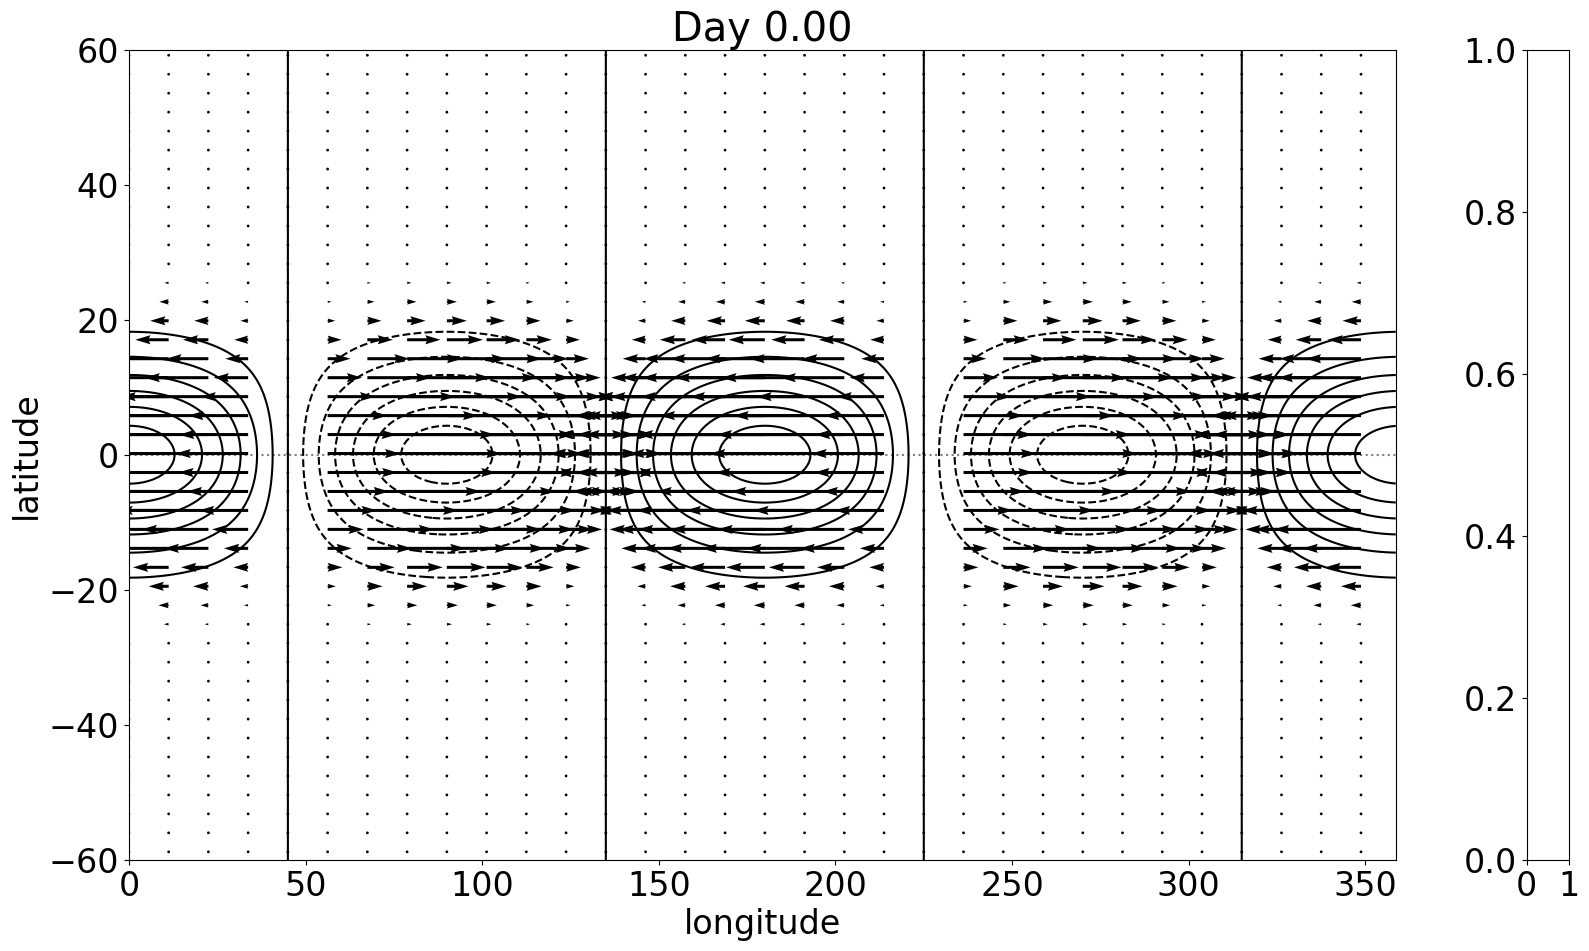

In [194]:
normalize_over_time = True

starting_frame = day_to_index(0)
ending_frame = day_to_index(360)
frame_interval = day_to_index(2)

latitude = ((np.pi / 2 - theta)*(180/np.pi)).squeeze()
longitude = (phi*(180/np.pi)).squeeze()

temperature_grand_max = np.max(output_temperature.values)
temperature_grand_min = np.min(output_temperature.values)
# temperature_levels = np.linspace(temperature_grand_min, temperature_grand_max, 15)
temperature_levels = 15

if simulation_moisture:
    moisture_grand_max = np.max(output_moisture.values)
    moisture_grand_min = np.min(output_moisture.values)
    # moisture_levels = np.linspace(moisture_grand_min, moisture_grand_max, 15)
    moisture_levels = 15

fig = plt.figure(figsize=(16,9))
gs = GridSpec(1, 2, width_ratios=[30,1], figure=fig)
gs.update(top=.95, bottom=0.05, left=0.05, right=.95)

ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

def update(t_index):
    ax.clear()
    cbar_ax.clear()
    
    # Scale the fields according to the upscale factor
    upscaling_factor = 8

    output_temperature_field = dist.Field(name='output_temperature', bases=basis)
    output_temperature_field['g'] = output_temperature.isel(t=t_index)
    output_temperature_field.change_scales(upscaling_factor)
        
    output_zonal_velocity_field = dist.Field(name='output_zonal_velocity', bases=basis)
    output_zonal_velocity_field['g'] = output_velocity.isel(t=t_index)[0]
    output_zonal_velocity_field.change_scales(upscaling_factor)
        
    output_meridional_velocity_field = dist.Field(name='output_meridional_velocity', bases=basis)
    output_meridional_velocity_field['g'] = output_velocity.isel(t=t_index)[1]
    output_meridional_velocity_field.change_scales(upscaling_factor)
    
    if simulation_moisture:
        output_moisture_field = dist.Field(name='output_moisture', bases=basis)
        output_moisture_field['g'] = output_moisture.isel(t=t_index)
        output_moisture_field.change_scales(upscaling_factor)

    if normalize_over_time:
        plotting_temperature_field = output_temperature_field['g']/np.max(output_temperature_field['g'])
        plotting_zonal_velocity_field = output_zonal_velocity_field['g']/np.max(output_temperature_field['g'])
        plotting_meridional_velocity_field = output_meridional_velocity_field['g']/np.max(output_temperature_field['g'])
        if simulation_moisture:
            plotting_moisture_field = output_moisture_field['g']/np.max(output_temperature_field['g'])

    else:
        plotting_temperature_field = output_temperature_field['g']
        plotting_zonal_velocity_field = output_zonal_velocity_field['g']
        plotting_meridional_velocity_field = output_meridional_velocity_field['g']
        if simulation_moisture:
            plotting_moisture_field = output_moisture_field['g']
        
    [output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)

    latitude = ((np.pi / 2 - output_theta)*(180/np.pi)).squeeze()
    longitude = (output_phi*(180/np.pi)).squeeze()

    ax.set_title(f"Day {downsampled_timepoints.isel(t=t_index)/SECONDS_PER_DAY:0.2f}")
    
    CS = ax.contour(
        longitude,
        latitude,
        plotting_temperature_field.T,
        colors = 'k',
        norm=mcolors.CenteredNorm(vcenter=0),
        levels = temperature_levels,
    )

    if simulation_moisture:
        CF = ax.contourf(
            longitude,
            latitude,
            # output_height.isel(t=t), 
            plotting_moisture_field.T,
            cmap='coolwarm', 
            levels = moisture_levels,
            norm=mcolors.CenteredNorm(vcenter=0),
        )
        fig.colorbar(CF, cax=cbar_ax)

    longitude_quiver_spacing = 8
    latitude_quiver_spacing = 8
    ax.quiver(
        longitude[::longitude_quiver_spacing],
        latitude[::latitude_quiver_spacing],
        -plotting_zonal_velocity_field.T[::latitude_quiver_spacing, ::longitude_quiver_spacing], 
        -plotting_meridional_velocity_field.T[::latitude_quiver_spacing, ::longitude_quiver_spacing], 
        # scale = 10*np.max(np.abs(output_zonal_velocity_field['g']))
    )
    ax.axhline(y=0, ls=':', color='k', alpha=0.5)
    ax.set_ylim(-60,60)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_aspect('auto')

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=60
)

anim.save(f"{output_file_directory}/{experiment_name}/{initial_condition_name}/global_plots_projected_animation.mp4", dpi=200)

## Pattern correlation

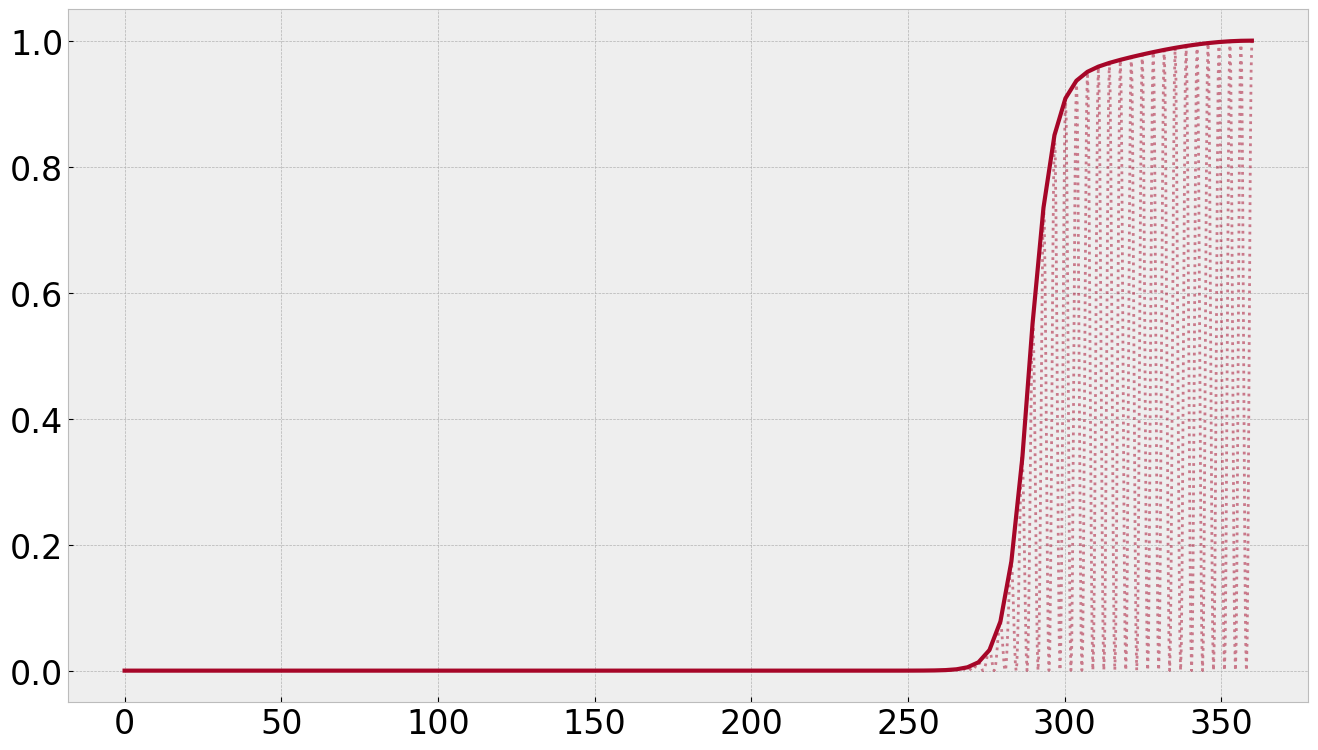

In [196]:
upscaling_factor = 1

final_moisture_field = dist.Field(name='final_moisture', bases=basis)
final_moisture_field['g'] = output_moisture.isel(t=-1)
final_moisture_field.change_scales(upscaling_factor)

[output_phi, output_theta] = dist.local_grids(basis, scales=upscaling_factor)

backward_pattern_correlation = np.zeros((len(downsampled_timepoints)))


for t in downsampled_timepoints.write_number:
    output_moisture_field = dist.Field(name='output_moisture', bases=basis)
    output_moisture_field['g'] = output_moisture.isel(t=t-1)
    output_moisture_field.change_scales(upscaling_factor)
    
    # Calculate the pattern correlation between
    backward_pattern_correlation[t-1] = np.einsum(
        'ij,ij->',
        output_moisture_field['g'], 
        final_moisture_field['g']
    ) / (
        np.std(output_moisture_field['g'])
        * np.std(final_moisture_field['g']) 
        * len(output_phi.squeeze()) 
        * len(output_theta.squeeze())
    )

peaks = sp.signal.find_peaks(backward_pattern_correlation**2)[0]
padded_peaks = np.insert(peaks, 0, 0)
padded_peaks = np.append(padded_peaks, len(downsampled_timepoints)-1)

plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))
ax.plot(
    downsampled_timepoints/(24*3600),
    backward_pattern_correlation**2,
    alpha=0.5,
    lw=2,
    ls=':',
    color=bmh_colors('red')
)

ax.plot(
    downsampled_timepoints[padded_peaks]/(24*3600),
    (backward_pattern_correlation[padded_peaks])**2,
    lw=3,
    color=bmh_colors('red')
)
plt.show()

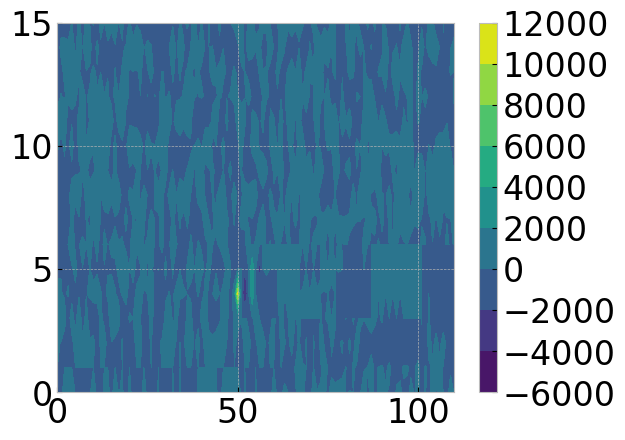

In [197]:
plt.contourf(
    output_temperature_field['c']
)
plt.colorbar()
plt.show()

In [200]:
output_temperature_field['g'].shape

(256, 512)